Aqui importamos os módulos os e shutil, que são utilizados para manipular ficheiros e caminhos/diretórios.

Defenimos tamabém os caminhos das pastas, onde estão contidos os conjuntos/set's de treino, validação e teste.

In [1]:
import os, shutil
train_dir = '../train'
validation_dir = '../validation'
test_dir = '../test'

Nao voltamos a repetir o erro dos modelos de feature extraction e defenimos logo o IMG_SIZE com tamanho de 150.

Criamos os conjuntos de dados de treino, validação e teste a partir dos respetivos diretórios. Assim, é especificado o caminho do diretório para cada um dos conjuntos anteriormente relatados.

O label_mode foi definido como categorical, tendo em conta que as labels são vetores one-hot encoded.

Posteriormente é definido o image_size, de forma a redimensionar todas as fotografias de input no respetivo conjunto, de forma a ter todas as fotografias do mesmo tamanho, sendo assim, se entrar na nossa rede uma fotografia 64x64, ela será redimensionada para o tamanho correto nesta fase.

In [2]:
from keras.utils import image_dataset_from_directory

IMG_SIZE = 150

train_dataset = image_dataset_from_directory(train_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE))
validation_dataset = image_dataset_from_directory(validation_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE))
test_dataset = image_dataset_from_directory(test_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE))

Found 40000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.


Devido ao grande fluxo de imagens que compõem este projeto, e devido ao treino desta rede ser significativamente mais demorado e lento, decidimos dividir todos os dataset's, nomeadamente, validation e train em 3 dataset's distintos para cada conjunto, de forma a otimizar o tempo de treino da nossa rede.

In [59]:
import tensorflow as tf

# Função para calcular o tamanho do dataset
def calculate_dataset_size(dataset):
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()
    return dataset_size

# Função para dividir o dataset em três subsets
def split_dataset(dataset, fractions):
    dataset_size = calculate_dataset_size(dataset)
    split_sizes = [int(fraction * dataset_size) for fraction in fractions]
    
    dataset_1 = dataset.take(split_sizes[0])
    dataset_2 = dataset.skip(split_sizes[0]).take(split_sizes[1])
    dataset_3 = dataset.skip(split_sizes[0] + split_sizes[1])
    
    return dataset_1, dataset_2, dataset_3

# Frações do dataset que você quer dividir
fractions = [0.4, 0.3, 0.3]

# Dividir o dataset de treino e validacao em três subsets
train_dataset_1, train_dataset_2, train_dataset_3 = split_dataset(train_dataset, fractions)
validation_dataset_1, validation_dataset_2, validation_dataset_3 = split_dataset(validation_dataset, fractions)

# Calculando os tamanhos dos subsets de treino
split_train_size_1 = calculate_dataset_size(train_dataset_1)
split_train_size_2 = calculate_dataset_size(train_dataset_2)
split_train_size_3 = calculate_dataset_size(train_dataset_3)

# Calculando os tamanhos dos subsets de validação
split_validation_size_1 = calculate_dataset_size(validation_dataset_1)
split_validation_size_2 = calculate_dataset_size(validation_dataset_2)
split_validation_size_3 = calculate_dataset_size(validation_dataset_3)

# Mostrar os tamanhos dos subsets de treino
print(f"Tamanho do subset 1 do conjunto de treino: {split_train_size_1}")
print(f"Tamanho do subset 2 do conjunto de treino: {split_train_size_2}")
print(f"Tamanho do subset 3 do conjunto de treino: {split_train_size_3}")

# Mostrar os tamanhos dos subsets de validação
print(f"Tamanho do subset 1 do conjunto de validação: {split_validation_size_1}")
print(f"Tamanho do subset 2 do conjunto de validação: {split_validation_size_2}")
print(f"Tamanho do subset 3 do conjunto de validação: {split_validation_size_3}")

Tamanho do subset 1 do conjunto de treinamento: 500
Tamanho do subset 2 do conjunto de treinamento: 375
Tamanho do subset 3 do conjunto de treinamento: 375
Tamanho do subset 1 do conjunto de validação: 125
Tamanho do subset 2 do conjunto de validação: 93
Tamanho do subset 3 do conjunto de validação: 95


O código importa a arquitetura da rede convolucional VGG19 pré-treinada através do módulo tensorflow.keras. A VGG19 é uma arquitetura de rede neural convolucional (CNN) renomada, conhecida por sua profundidade e eficácia em tarefas de reconhecimento de imagens. 

weights='imagenet', indica que os pesos da rede foram inicializados com os valores aprendidos a partir do conjunto de dados ImageNet. 

include_top=False, configura a VGG19 para não incluir a fully connected layer no topo da rede. Isto permite-nos que os recursos extraídos pela VGG19 sejam utilizados como entrada para camadas posteriormente defenidas por nós, adequadas para uma tarefa específica, neste caso iremos usar o modelo pré treinado no ficheiro ModelT_transferLearning_featureExtraction_WithoutDataAumentation_OnlyClassification.h5 para classificação. A razão pela qual decidimos utilizar a estrategia referida anteriormente é porque para realizar o fine tuning devemos seguir os seguintes passos:
1. Adicionar a nossa rede personalizada em cima de uma rede base já treinada
2. Congelar a rede base (vgg19)
3. Treinar a parte que adicionámos(rede personalizada)
4. Descongelar algumas camadas da rede base (vgg19)
5. Treinar os dois modelos em conjunto o que adicionámos(rede personalizada) e o modelo base(vgg19)

Ao realizarmos esta estrategia é devido ao facto que podemos logo saltar para o ponto 3, reutilizando trabalho realizado.

input_shape=(IMG_SIZE, IMG_SIZE, 3) especifica o formato esperado para as imagens de entrada na rede.

In [60]:
from keras.applications.vgg19 import VGG19

conv_base = VGG19(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)) 
conv_base.trainable = True

# Deixar todas as camadas, exceto as últimas quatro, não treináveis (congeladas)
for layer in conv_base.layers[:-5]: 
    layer.trainable = False

Fazer import do modelo que irá ser usado para classificação, e ver a sua arquitetura

In [61]:
from tensorflow import keras

#Adicionar o modelo treinado com feature extraction
base_model = keras.models.load_model('models/ModelT_transferLearning_featureExtraction_WithoutDataAumentation_OnlyClassification.h5')

base_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 4, 4, 512)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               4194816   
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                           

No seguinte bloco de código é onde fazemos a junção dos dois modelos, da CNN(Modelo usado para reconhecimento de imagens) e da NN(Modelo usado para classificação das imagens)

In [62]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

#Criar uma camada de input com o mesmo shape da vgg19
input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

#Passar a camada de input para o modelo base VGG19
vgg19_output = conv_base(input_layer)

#Passar a saída do VGG19 para do modelo salvo
model_output = base_model(vgg19_output)

#Criar o novo modelo combinado com a vgg19 e o modelo pré treinado
model= Model(inputs=input_layer, outputs=model_output)

# Mostrar os modelos combinados num só
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 model_1 (Functional)        (None, 10)                4201994   
                                                                 
Total params: 24226378 (92.42 MB)
Trainable params: 13640202 (52.03 MB)
Non-trainable params: 10586176 (40.38 MB)
_________________________________________________________________


A seguinte função foi usada para verificar a junção dos modelos e para verificar que as camadas da vgg19 estávam como Trainable=True (atualizará os pesos ao longo do processo de treino), no output conseguimos concluir que defenimos o block5 como Trainable=True. Posteriormente, planeamos descongelar mais camadas se o modelo não apresentar overfitting, visando aumentar ainda mais sua validation accuracy

In [63]:
# Função para imprimir o estado das camadas de forma recursiva
def print_layer_trainable_status(layer, indent=0):
    print(f"{' ' * indent}Layer: {layer.name}, Trainable: {layer.trainable}")
    if isinstance(layer, Model):
        for sub_layer in layer.layers:
            print_layer_trainable_status(sub_layer, indent + 2)

print_layer_trainable_status(model)

Layer: model_4, Trainable: True
  Layer: input_10, Trainable: True
  Layer: vgg19, Trainable: True
    Layer: input_9, Trainable: False
    Layer: block1_conv1, Trainable: False
    Layer: block1_conv2, Trainable: False
    Layer: block1_pool, Trainable: False
    Layer: block2_conv1, Trainable: False
    Layer: block2_conv2, Trainable: False
    Layer: block2_pool, Trainable: False
    Layer: block3_conv1, Trainable: False
    Layer: block3_conv2, Trainable: False
    Layer: block3_conv3, Trainable: False
    Layer: block3_conv4, Trainable: False
    Layer: block3_pool, Trainable: False
    Layer: block4_conv1, Trainable: False
    Layer: block4_conv2, Trainable: False
    Layer: block4_conv3, Trainable: False
    Layer: block4_conv4, Trainable: False
    Layer: block4_pool, Trainable: False
    Layer: block5_conv1, Trainable: True
    Layer: block5_conv2, Trainable: True
    Layer: block5_conv3, Trainable: True
    Layer: block5_conv4, Trainable: True
    Layer: block5_pool, Trainabl

O seguinte bloco de codigo mostra:

model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-5, weight_decay=1e-1),metrics=['accuracy']):

-> Lloss: Utiliza a função loss categorical_crossentropy, adequada para problemas de classificação multiclasse.

-> optimizer: Configura o otimizador Adam com uma taxa de aprendizado inicial de 1e-5 e weight_decay=1e-2 para penalizar os pesos maiores e ajudar a reduzir o overfitting.



early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True):

-> monitor e patience: Monitora a funcao loss, com pacieca de 15 épocas, interrompe o treino se a loss não melhorar após 15 épocas

-> restore_best_weights: restaura os pesos do modelo para a época com a melhor métrica de validação 



reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6):

-> monitor e patience: Monitora a funcao loss, com pacieca de 5 épocas, ou seja muda o lerning rate se a métrica monitorada(neste caso a loss) não mostrar melhorias após um número específico de épocas (patience), o lerning rate é reduzido de acordo com o factor

-> min_lr: limite inferior que o lerning rate pode chegar

In [64]:
#A partir deste bloco iremos treinar o modelo para os sub datasets
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-5, weight_decay=1e-1),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-7)

O seguinte bloco de código mostra um dos vários treinos realizados, nele usamos o subdataset 2, nele especificamos o numero de epocas como 7, o batch size como 32, ou seja o numero de amostras processadas de uma vez durante cada iteração do treino, incluimos os callbacks descritos acima

In [65]:
#Subset 2
history = model.fit(train_dataset_2, epochs=7, validation_data=validation_dataset_2, batch_size=64, callbacks=[early_stopping, reduce_lr])

Epoch 1/7
375/375 [==============================] - 1416s 4s/step - loss: 0.7403 - accuracy: 0.7840 - val_loss: 0.4932 - val_accuracy: 0.8370 - lr: 1.0000e-05
Epoch 2/7
375/375 [==============================] - 1349s 4s/step - loss: 0.4708 - accuracy: 0.8474 - val_loss: 0.4342 - val_accuracy: 0.8589 - lr: 1.0000e-05
Epoch 3/7
375/375 [==============================] - 1347s 4s/step - loss: 0.3326 - accuracy: 0.8851 - val_loss: 0.4081 - val_accuracy: 0.8646 - lr: 1.0000e-05
Epoch 4/7
375/375 [==============================] - 1352s 4s/step - loss: 0.2566 - accuracy: 0.9098 - val_loss: 0.4087 - val_accuracy: 0.8666 - lr: 1.0000e-05
Epoch 5/7
375/375 [==============================] - 1358s 4s/step - loss: 0.1861 - accuracy: 0.9357 - val_loss: 0.3938 - val_accuracy: 0.8716 - lr: 2.0000e-06
Epoch 6/7
375/375 [==============================] - 1359s 4s/step - loss: 0.1654 - accuracy: 0.9452 - val_loss: 0.3956 - val_accuracy: 0.8726 - lr: 2.0000e-06
Epoch 7/7
375/375 [=====================

O seguinte bloco de código mostra, a realização de um gráfico época a época, onde são registados e visualizados os respetivos valores de accuracy e loss do nosso modelo. Este ponto é muito importante, para poder comparar a evolução entre as épocas de um treino, bem como, por exemplo, quando realizamos alterações à rede e queremos ver a evolução comparando com versões anteriores.

O resultado mostra-nos que o modelo esta com overfiting e a começar a estagnar nos 0.875

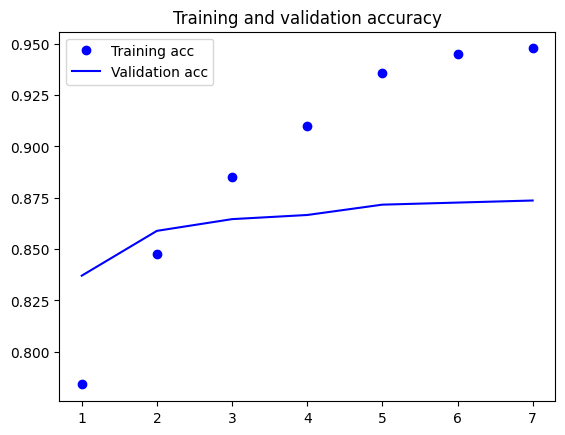

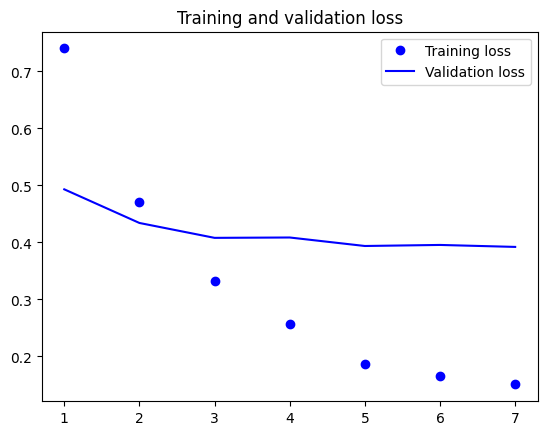

In [69]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()
plt.show()

Agora iremos tentar reduzir o overfiting aumentado o weight_decay e também reduzimos o lerning rate, se o modelo melhorar iremos descongelar mais camadas da parte convolucional

In [70]:
#Subset 1
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-6, weight_decay=0.5),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-7)

history = model.fit(train_dataset_1, epochs=2, validation_data=validation_dataset_1, batch_size=64, callbacks=[early_stopping, reduce_lr]) 

Epoch 1/2
500/500 [==============================] - 1830s 4s/step - loss: 0.4690 - accuracy: 0.8568 - val_loss: 0.3903 - val_accuracy: 0.8815 - lr: 1.0000e-06
Epoch 2/2
500/500 [==============================] - 1820s 4s/step - loss: 0.4451 - accuracy: 0.8652 - val_loss: 0.3864 - val_accuracy: 0.8830 - lr: 1.0000e-06


No final do treino podemos verificar que o overfitting melhorou

In [71]:
#Subset 3 -> Continuar com os mesmos valores
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-6, weight_decay=0.5),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-7)

history = model.fit(train_dataset_3, epochs=4, validation_data=validation_dataset_3, batch_size=64, callbacks=[early_stopping, reduce_lr]) 

Epoch 1/4
375/375 [==============================] - 1378s 4s/step - loss: 0.4968 - accuracy: 0.8505 - val_loss: 0.3921 - val_accuracy: 0.8743 - lr: 1.0000e-06
Epoch 2/4
375/375 [==============================] - 1389s 4s/step - loss: 0.4539 - accuracy: 0.8602 - val_loss: 0.3868 - val_accuracy: 0.8783 - lr: 1.0000e-06
Epoch 3/4
375/375 [==============================] - 1387s 4s/step - loss: 0.4227 - accuracy: 0.8673 - val_loss: 0.3817 - val_accuracy: 0.8780 - lr: 1.0000e-06
Epoch 4/4
375/375 [==============================] - 1399s 4s/step - loss: 0.3984 - accuracy: 0.8723 - val_loss: 0.3735 - val_accuracy: 0.8810 - lr: 1.0000e-06


Guardar o modelo

In [72]:
model.save('models/ModelT_transferLearning_fineTuning_WithoutDataAumentation.h5')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Tal como tinhamos planeado se o modelo deixa-se de ter overfitting, iríamos descongelar mais layers da vgg19 para conseguir alcançar a convergência do modelo

No seguinte bloco de código descongelamos mais 5 camadas da vgg19, ou seja todo o block4 irá ficar todo como Trainable=True, atualizará os pesos ao longo do processo de treino

In [75]:
#Vamos colocar mais 5 camadas da vgg como treinaveis, ou seja o bloco 4 para ajustar os pesos
for layer in conv_base.layers[:-10]:
    layer.trainable = True
 
# Função para imprimir para verificar se o bloco 4 ficou com Trainable=true
def print_layer_trainable_status(model):
    for layer in model.layers:
        print(f"Layer: {layer.name}, Trainable: {layer.trainable}")

print_layer_trainable_status(conv_base)

Layer: input_9, Trainable: False
Layer: block1_conv1, Trainable: False
Layer: block1_conv2, Trainable: False
Layer: block1_pool, Trainable: False
Layer: block2_conv1, Trainable: False
Layer: block2_conv2, Trainable: False
Layer: block2_pool, Trainable: False
Layer: block3_conv1, Trainable: False
Layer: block3_conv2, Trainable: False
Layer: block3_conv3, Trainable: False
Layer: block3_conv4, Trainable: False
Layer: block3_pool, Trainable: False
Layer: block4_conv1, Trainable: True
Layer: block4_conv2, Trainable: True
Layer: block4_conv3, Trainable: True
Layer: block4_conv4, Trainable: True
Layer: block4_pool, Trainable: True
Layer: block5_conv1, Trainable: True
Layer: block5_conv2, Trainable: True
Layer: block5_conv3, Trainable: True
Layer: block5_conv4, Trainable: True
Layer: block5_pool, Trainable: True


A seguinte função foi usada para verificar que as camadas da vgg19 estávam como Trainable=True (atualizará os pesos ao longo do processo de treino), no output conseguimos concluir que defenimos o block4 também como Trainable=True. Posteriormente, teremos de analisar os resultados para verificar se faz ou nao sentido descongelar mais camadas.

In [87]:
# Função para imprimir o estado das camadas de forma recursiva
def print_layer_trainable_status(layer, indent=0):
    print(f"{' ' * indent}Layer: {layer.name}, Trainable: {layer.trainable}")
    if isinstance(layer, Model):
        for sub_layer in layer.layers:
            print_layer_trainable_status(sub_layer, indent + 2)

print_layer_trainable_status(model)

Layer: model_5, Trainable: True
  Layer: input_11, Trainable: True
  Layer: vgg19, Trainable: True
    Layer: input_9, Trainable: False
    Layer: block1_conv1, Trainable: False
    Layer: block1_conv2, Trainable: False
    Layer: block1_pool, Trainable: False
    Layer: block2_conv1, Trainable: False
    Layer: block2_conv2, Trainable: False
    Layer: block2_pool, Trainable: False
    Layer: block3_conv1, Trainable: False
    Layer: block3_conv2, Trainable: False
    Layer: block3_conv3, Trainable: False
    Layer: block3_conv4, Trainable: False
    Layer: block3_pool, Trainable: False
    Layer: block4_conv1, Trainable: True
    Layer: block4_conv2, Trainable: True
    Layer: block4_conv3, Trainable: True
    Layer: block4_conv4, Trainable: True
    Layer: block4_pool, Trainable: True
    Layer: block5_conv1, Trainable: True
    Layer: block5_conv2, Trainable: True
    Layer: block5_conv3, Trainable: True
    Layer: block5_conv4, Trainable: True
    Layer: block5_pool, Trainable: Tr

Continuar com os treinos para ver se o modelo tem melhorias

In [76]:
#Subset 3 -> Continuar com os mesmos valores
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-6, weight_decay=0.5),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-7)

history = model.fit(train_dataset_3, epochs=4, validation_data=validation_dataset_3, batch_size=64, callbacks=[early_stopping, reduce_lr]) 

Epoch 1/4
375/375 [==============================] - 2383s 6s/step - loss: 0.3817 - accuracy: 0.8783 - val_loss: 0.3651 - val_accuracy: 0.8876 - lr: 1.0000e-06
Epoch 2/4
375/375 [==============================] - 2518s 7s/step - loss: 0.3395 - accuracy: 0.8873 - val_loss: 0.3516 - val_accuracy: 0.8889 - lr: 1.0000e-06
Epoch 3/4
375/375 [==============================] - 2142s 6s/step - loss: 0.3166 - accuracy: 0.8953 - val_loss: 0.3464 - val_accuracy: 0.8889 - lr: 1.0000e-06
Epoch 4/4
375/375 [==============================] - 1996s 5s/step - loss: 0.2827 - accuracy: 0.9062 - val_loss: 0.3455 - val_accuracy: 0.8886 - lr: 1.0000e-06


No output final conseguimos verificar que o modelo obteve melhorias porem está com overfitting

In [78]:
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-5, weight_decay=0.5),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-7)

history = model.fit(train_dataset_1, epochs=5, validation_data=validation_dataset_1, batch_size=64, callbacks=[early_stopping, reduce_lr]) 

Epoch 1/5
500/500 [==============================] - 2654s 5s/step - loss: 0.4189 - accuracy: 0.8694 - val_loss: 0.3472 - val_accuracy: 0.8955 - lr: 1.0000e-05
Epoch 2/5
500/500 [==============================] - 2676s 5s/step - loss: 0.2605 - accuracy: 0.9137 - val_loss: 0.3225 - val_accuracy: 0.8988 - lr: 1.0000e-05
Epoch 3/5
500/500 [==============================] - 2655s 5s/step - loss: 0.1808 - accuracy: 0.9364 - val_loss: 0.3233 - val_accuracy: 0.9080 - lr: 1.0000e-05
Epoch 4/5
500/500 [==============================] - 2664s 5s/step - loss: 0.1100 - accuracy: 0.9624 - val_loss: 0.2880 - val_accuracy: 0.9110 - lr: 2.0000e-06
Epoch 5/5
500/500 [==============================] - 2658s 5s/step - loss: 0.0870 - accuracy: 0.9716 - val_loss: 0.2903 - val_accuracy: 0.9118 - lr: 2.0000e-06


Verificar os resultados obtidos através de vizualização gráfica

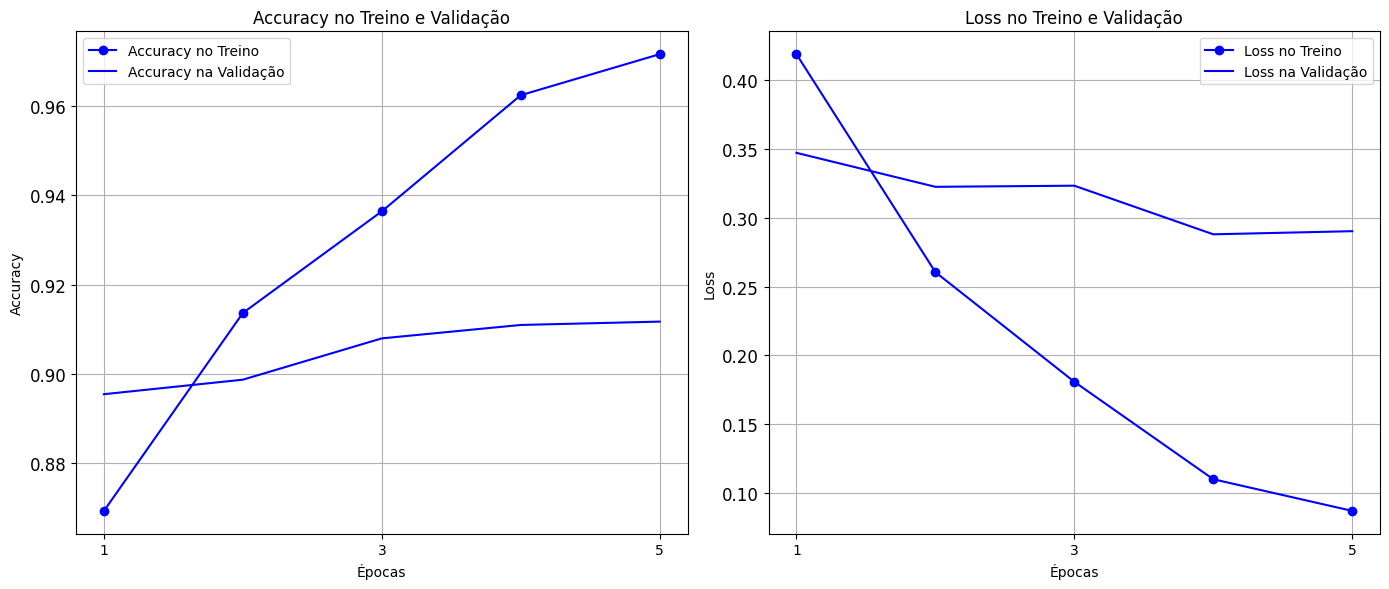

In [82]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 6))

# Gráfico da Accuracya
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Accuracy no Treino')
plt.plot(epochs, val_acc, 'b-', label='Accuracy na Validação')
plt.title('Accuracy no Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True) 
plt.xticks(range(1, len(acc) + 1, 2))  
plt.yticks(fontsize=12) 
plt.tight_layout()

# Gráfico da Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Loss no Treino')
plt.plot(epochs, val_loss, 'b-', label='Loss na Validação')
plt.title('Loss no Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True) 
plt.xticks(range(1, len(acc) + 1, 2))
plt.yticks(fontsize=12) 
plt.tight_layout()

# Mostrar os gráficos
plt.show()


Antes de descongelar as proximas camadas verificamos que o modelo se manteve, tendo melhorias pouco significativas

In [84]:
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-6, weight_decay=0.5),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-7)

history = model.fit(train_dataset_1, epochs=2, validation_data=validation_dataset_1, batch_size=64, callbacks=[early_stopping, reduce_lr]) 

Epoch 1/2
500/500 [==============================] - 2871s 6s/step - loss: 0.0725 - accuracy: 0.9765 - val_loss: 0.2871 - val_accuracy: 0.9140 - lr: 1.0000e-06
Epoch 2/2
500/500 [==============================] - 2811s 6s/step - loss: 0.0641 - accuracy: 0.9804 - val_loss: 0.2834 - val_accuracy: 0.9153 - lr: 1.0000e-06


In [88]:
model.save('models/ModelT_transferLearning_fineTuning_WithoutDataAumentation.h5')

Iremos ver como reage o modelo ao descongelar também o block3

Verificar que as camadas estão defenidas como Trainable=True

In [91]:
#Vamos colocar mais 5 camadas da vgg como treinaveis, ou seja o bloco 3 para ajustar os pesos
for layer in conv_base.layers[-15:]:
    layer.trainable = True
 
# Função para imprimir para verificar se o bloco 4 ficou com Trainable=true
def print_layer_trainable_status(model):
    for layer in model.layers:
        print(f"Layer: {layer.name}, Trainable: {layer.trainable}")

print_layer_trainable_status(conv_base)

Layer: input_9, Trainable: False
Layer: block1_conv1, Trainable: False
Layer: block1_conv2, Trainable: False
Layer: block1_pool, Trainable: False
Layer: block2_conv1, Trainable: False
Layer: block2_conv2, Trainable: False
Layer: block2_pool, Trainable: False
Layer: block3_conv1, Trainable: True
Layer: block3_conv2, Trainable: True
Layer: block3_conv3, Trainable: True
Layer: block3_conv4, Trainable: True
Layer: block3_pool, Trainable: True
Layer: block4_conv1, Trainable: True
Layer: block4_conv2, Trainable: True
Layer: block4_conv3, Trainable: True
Layer: block4_conv4, Trainable: True
Layer: block4_pool, Trainable: True
Layer: block5_conv1, Trainable: True
Layer: block5_conv2, Trainable: True
Layer: block5_conv3, Trainable: True
Layer: block5_conv4, Trainable: True
Layer: block5_pool, Trainable: True


Verificar o modelo completo

In [92]:
# Função para imprimir o estado das camadas de forma recursiva
def print_layer_trainable_status(layer, indent=0):
    print(f"{' ' * indent}Layer: {layer.name}, Trainable: {layer.trainable}")
    if isinstance(layer, Model):
        for sub_layer in layer.layers:
            print_layer_trainable_status(sub_layer, indent + 2)

print_layer_trainable_status(model)

Layer: model_5, Trainable: True
  Layer: input_11, Trainable: True
  Layer: vgg19, Trainable: True
    Layer: input_9, Trainable: False
    Layer: block1_conv1, Trainable: False
    Layer: block1_conv2, Trainable: False
    Layer: block1_pool, Trainable: False
    Layer: block2_conv1, Trainable: False
    Layer: block2_conv2, Trainable: False
    Layer: block2_pool, Trainable: False
    Layer: block3_conv1, Trainable: True
    Layer: block3_conv2, Trainable: True
    Layer: block3_conv3, Trainable: True
    Layer: block3_conv4, Trainable: True
    Layer: block3_pool, Trainable: True
    Layer: block4_conv1, Trainable: True
    Layer: block4_conv2, Trainable: True
    Layer: block4_conv3, Trainable: True
    Layer: block4_conv4, Trainable: True
    Layer: block4_pool, Trainable: True
    Layer: block5_conv1, Trainable: True
    Layer: block5_conv2, Trainable: True
    Layer: block5_conv3, Trainable: True
    Layer: block5_conv4, Trainable: True
    Layer: block5_pool, Trainable: True
  

Apos a realização deste treino não observamos melhorias, portanto concluímos que ao descongelar o block3, não iria ajudar o modelo a obter melhores resultados

In [93]:
#Aumetar o weight_decay para tentar reduzir o overfitting
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-6, weight_decay=0.5),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-7)

history = model.fit(train_dataset_1, epochs=2, validation_data=validation_dataset_1, batch_size=32, callbacks=[early_stopping, reduce_lr]) 

Epoch 1/2
500/500 [==============================] - 3850s 8s/step - loss: 0.0581 - accuracy: 0.9822 - val_loss: 0.2867 - val_accuracy: 0.9120 - lr: 1.0000e-06
Epoch 2/2
500/500 [==============================] - 3806s 8s/step - loss: 0.0553 - accuracy: 0.9824 - val_loss: 0.2869 - val_accuracy: 0.9143 - lr: 1.0000e-06


Carregar o modelo para testá-lo com o dataset de validação e de teste

In [4]:
from tensorflow import keras

loaded_model = keras.models.load_model('models/ModelT_transferLearning_fineTuning_WithoutDataAumentation.h5')

val_loss, val_acc = loaded_model.evaluate(validation_dataset)
print('val_acc:', val_acc)

313/313 [==============================] - 649s 2s/step - loss: 0.2793 - accuracy: 0.9146
val_acc: 0.9146000146865845


In [5]:
val_loss, val_acc = loaded_model.evaluate(test_dataset) 
print('val_acc:', val_acc)

313/313 [==============================] - 743s 2s/step - loss: 0.2896 - accuracy: 0.9110
val_acc: 0.9110000133514404


Aqui, preparamos uma função para extrair as features com o modelo.

In [15]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

def extract_features(dataset, model):
    features = []
    for batch in dataset:
        images, _ = batch
        features_batch = model.predict(images)
        features.append(features_batch)
    return np.concatenate(features, axis=0)

Fazer load do modelo anteriormente gravado. Aqui utilizamos uma variável auxiliar de forma a não ser confundida com a variável load_model.

In [16]:
loaded_model_for_getFeatures = keras.models.load_model('models/ModelT_transferLearning_fineTuning_WithoutDataAumentation.h5')

Aplicar a função que relatámos anteriormente aos três dataset's: Treino, Validação e Teste.

In [17]:
train_features = extract_features(train_dataset, loaded_model_for_getFeatures)
validation_features = extract_features(validation_dataset, loaded_model_for_getFeatures)
test_features = extract_features(test_dataset, loaded_model_for_getFeatures)

1/1 [==============================] - 1s 1s/step


Por fim, guardamos as features anteriormente extraidas.

In [19]:
import numpy as np

save_path = 'features/ModelT_transferLearning_fineTuning_WithoutDataAumentation/'

np.save(save_path + 'train_features_dataset.npy', train_features)

np.save(save_path + 'val_features_dataset.npy', validation_features)

np.save(save_path + 'test_features_dataset.npy', test_features)

Como principal extra do nosso projeto, para além do optimizer utilizado, tipos de data augmentation utilizados e outras funções que vão para além das utilizadas nas aulas, decidimos desenvolver um website que utiliza os modelos dos nossos notebook's. Assim, foi necessário utilizar o tensorflowjs_converter, que é uma biblioteca python, que permite converter o modelo de formato h5 para json, de forma a ser possível implementar a utilização do respetivo modelo no website. Posteriormente a este passo, e após termos o modelo em json, implementámos o código via JavaScript que faz a interligação entre o website e o modelo. O código JavaScript está disponível no ficheiro da diretoria ./web/main.js.

Para utilizar o nosso website, visto que não está publicado na web, é necessário instalar o VSCode e a respetiva extensão de live server, e correr o ficheiro index.html na diretoria ./web/index.html. A interação com a app web é simples, selecionar o tipo de modelo a ser utilizado, selecionar uma fotografia e realizar a operação de predict chamando o nosso modelo, por sua vez em json. Por fim, será apresentada uma label com a predicted class e também um gráfico de API Alphabet Google com as probabilidades para cada classe da nossa rede. O nosso website, permite também alternar entre tema claro e escuro, conforme a preferência do utilizador.

Infelizmente, devido a uma incompatibilidade entre o tensorflowjs e a rede VGG19, não foi possível implementar este modelo na versão web.

Assim, apresentamos um exemplo da interface web que podem esperar:

![GUI do website](../img/GUI.png "GUI do website")


Para gerir e trabalhar em grupo neste projeto, foi utilizado o software GitHub. O nosso repositório GitHub cumpre com toda a organização e logística que são essênciais para um projeto na nossa área. 

Explicação dos objetivos de cada pasta do nosso Repositório (Para respetiva consulta de informação):
##### Pasta DOC: Contém o enunciado do projeto
##### Pasta WEB: Contém o Website desenvolvido relatado anteriormente
##### Pastas TEST, VALIDATION e TRAIN: Contém os dataset's de teste, validação e treino, respetivamente, da nossa rede
##### Pasta NOTEBOOKS: Contém os nossos notebook's com output e comentários, bem como as suas versões clean e os modelos gerados pelo treino da rede bem como a conversão para JSON
##### Pasta RESULTS: Contém os resultados dos treinos das nossas redes (Importante a sua consulta)
##### Pasta IMG: Contém imagens auxiliáres
##### Ficheiro README: Contém a apresentação do projeto e a distinção das pastas de treino/validação (dataset's)
##### Ficheiro NOTAS: Contém notas que pretendemos guardas para consulta posterior (Apenas para partilhar informalção entre os membros do grupo)

Para consulta deixamos o seguinte link (carregar em cima da fotografia do ícone do GitHub):

[![GitHub](../img/github-logo.png)](https://github.com/goncaloferreira966/Projeto_IA)]

### Powered By:
##### Gonçalo Ferreira, nº 2222051
##### José Delgado, nº 2222049